# Fast LOLA (Layer nOrm + Linear + Activation) using Triton

In [1]:
import torch.nn.functional as F


def torch_lola(x, weights, bias):
    *_, C = x.shape

    x = F.layer_norm(x, (C, ))
    x = F.linear(x, weights, bias)
    x = F.gelu(x)

    return x

The composition of layer norm + linear layer + activation function (shown above) is a common feature of language models. In this blog post, I will develop a Triton kernel which fuses these three operations and achieves a **> 2x** speed-up over the PyTorch implementation in the above listing.

My efforts to speed up the 'lola' operations were inspired by [my on-going work on a faster version of GPT-2 written in JAX](https://github.com/tristanheywood/nimbleGPT). In this project, I have been exploring the use of [OpenAI's Triton](https://github.com/openai/triton), along with [jax-triton](https://github.com/jax-ml/jax-triton) - a library for using Triton with JAX. Triton allows CUDA kernels to be written in Python, allowing users to combine the performance of custom CUDA kernels with the ease-of-development of Python.

The current boom in consumer-facing large generative models has made model inference speed and efficiency a key concern. The compute required to handle thousands or even millions of queries is considerable. Some reports have estimated that OpenAI is spending $100,000 per day on compute resources for ChatGPT. Improvements in model inference can both improve user experience (by reducing latency), and save considerable amounts of money.

The LOLA operation sequence appears just after each self-attention layer in GPT-2. A identical or similar sequence of operations appears in other LLMs as well. I am currently working on adapting the implementation to work with the 'RMSNorm', which should allow for a small performance improvement in Meta's recent LLaMA model.

# Background

This section briefly explains how model inference is actually performed on a modern GPU and why 'kernel fusion' can have such a large performance impact.

## Kernel Fusion

The primary purpose of Triton is to allow for the easy development of custom CUDA kernels, but why is this a big deal? No matter which Python framework you're using for ML, your model implementation will consist of a series of 'operations', such as matrix multiplications, convolutions, activation functions, normalizations, etc. For an operation like `torch.matmul`, PyTorch includes a CUDA kernel which is invoked to perform this operation. When exeucting a model, the model's weights and intermediate activations will be stored in GPU DRAM memory. Executing an operation involves copying the required data from DRAM to GPU registers, performing the operation, and copying the results back to DRAM. 

Unfortunately, recent advances in GPU architectures have seen improvements in computation speeds significantly outpace improvements in memory bandwidth. A significant fraction of the time spent executing a model is spent waiting for data to be copied from DRAM to GPU registers. The solution to this is to merge multiple operations into a single CUDA kernel, so that less data must be transferred for the same computation. This process is known as **Kernel Fusion** (also known as **Operator Fusion**), and is the primary uses case for Triton.

<img src="https://pbs.twimg.com/media/FjzAsy-UYAAeptC?format=jpg&name=large" height="300px">

<img src="https://pbs.twimg.com/media/FjzAvZBVsAAXiQP?format=jpg&name=large" height="300px">

(from https://twitter.com/cHHillee)

## GPU Architecture

To understand why the LOLA kernel developed in the notebook is structured the way it is, some knowledge of GPU architectures is required.

Analogous to how CPUs have multiple cores, GPUs have multiple 'Streaming Multiprocessors' (SMs). The A100 GPU for example, has 108 SMs. Executing a kernel on a GPU typically involves multiple SMs executing the same kernel simultaneously, but on different data. For example, you could write a matrix multiplication kernel where each SM was responsible for a single element of the output matrix. Each SM would therefore be running the same code, but on a unique row and column combination.

Each SM has its own dedicated 'on-chip' Shared Memory (SRAM). When an SM executes a kernel, it first loads the required data from DRAM into its SRAM, then performs the computation. The amount of SRAM per SM is typically very small compared to the GPU's DRAM. The A100 has 40 GB of DRAM but only 192KB of SRAM per SM. As a result, it is typically optimal for compute kernels to stream data from DRAM to SRAM as they need it, rather than loading the entire input into SRAM at the start of the kernel. For example if an SM was computing the dot-product of two vectors (e.g. a row and a column of a matrix - as is required during matrix multiplication), the SM might load blocks of 128 elements at a time from DRAM into SRAM, perform the dot-product on those 128 elements, and then load the next 128 elements.

The SRAM limitations have significant implications for our LOLA kernel. The linear layer and activation function can be fused together pretty easily - we just need to write a matrix multiplication kernel and then just before we write the results back to DRAM, we apply the activation function to each element. The Layer Norm is more difficult to fuse. The issue is that computing the mean and variance of each embedding in the batch requires reading in that full embedding from DRAM. Unfortunately, this is impossible due to SRAM limits.

# LOLA Kernel Derivation

<img src="https://media.tenor.com/27_dSZxHPcwAAAAd/futurama-math.gif" height="250px" />

In this section I show how we can re-arrange the mathematical operations performed in LOLA in order to derive an expression for the output which lets us stream the input data.

## Streaming the Layer Norm

In the background section, we saw that due the nature of GPU architectures, our kernel must stream the input data from DRAM and perform the calculation incrementally, piece-by-piece (as opposed to loading the whole input at once and performing the calculations in one hit).

Computing the layer norm using a single streaming pass over the input is impossible - we don't know the final results for each element until we know the mean and variance, and we don't know these until we've seen the entire input.

I have discovered however, that it **is** possible to compute a combined layer norm and matrix multiplication, in a single streaming pass! We can derive this result by algebraic manipulation of the LOLA operation sequence. To best of my knowledge this is a novel result, however it seems very likely that it has been discovered before.

## Streaming LOLA

Let's examine the process of computing a single element of the LOLA output. LOLA operates on a batch $\bm{X}$ of input embeddings. Consider a single embedding $\bm{x} = \bm{X}_{i, :}$, in the batch, and a single element $y = \bm{y}_j$ of the LOLA output vector $\bm{y}$ for this embedding. $y$ is calculated by taking the dot product of $\bm{x}$ with the $j^{th}$ column $\bm{w} = \bm{W}_{:, j}$ of the weights matrix and adding a bias term $b = \bm{b}_j$. The full expression for $y$, including layer norm and activation, is:

$$
\begin{align}
    y = \text{GELU} \left( \bm{w} \cdot \left( \frac{\bm{x} - \text{mean}(\bm{x})\bm{I}_{n}}{\sqrt{\text{var}(\bm{x}) + \epsilon}} \right) + b \right)
\end{align}
$$

Where $n$ is the number of elements in $\bm{x}$. We use multiplication by $\bm{I}_{n}$ as the mathematical equivalent of broadcasting. Here we use the GELU activation because this is what is used by GPT-2, however the result is the same for any activation function.

To compute this output by streaming, we need to find a way to express this computation that allows us to perform it by iterating over $\bm{x}$ and $\bm{w}$. This is not possible with the current expression, because we won't know $\text{mean}(\bm{x})$ until we have iterated over all of $\bm{x}$.

To this end, observe that:

$$
\begin{align}
    \bm{w} \cdot \left( \frac{\bm{x} - \text{mean}(\bm{x})\bm{I}_n}{\sqrt{\text{var}(\bm{x}) + \epsilon}} \right) &= \frac{1}{\sqrt{\text{var}(\bm{x}) + \epsilon}} \left( \bm{w} \cdot \bm{x} - \bm{w} \cdot \text{mean}(\bm{x}) \bm{I}_n\right) \\
\end{align}
$$

Now by the definition of the dot product: $\bm{w} \cdot \text{mean}(\bm{x}) \bm{I}_n = \sum_k w_k \cdot \text{mean}(\bm{x}) = \text{mean}(\bm{x}) \times \text{sum}(\bm{w})$. Note also that $\text{var}(\bm{x}) = \text{mean}(\bm{x}^2) - \text{mean}(\bm{x})^2$. We can therefore compute the required output from the following pieces, all of which can be computed incrementally by streaming $\bm{w}$ and $\bm{x}$!

$$
\begin{align}
    \bm{w} \cdot \bm{x} && \text{sum}(\bm{w}) && \text{mean}(\bm{x}) && \text{mean}(\bm{x}^2) \\
\end{align}
$$

The equation for the output in terms of these pieces is:

$$
\begin{align}
    y = \text{GELU} \left( \frac{\bm{w} \cdot \bm{x} - \text{mean}(\bm{x}) \times \text{sum}(\bm{w})}{\sqrt{\text{mean}(\bm{x}^2) - \text{mean}(\bm{x})^2 + \epsilon}} + b \right)
\end{align}
$$



## Checking the Math

To check our working, we can implement this re-arranged computation in code and compare its output to the Lola functions above:

In [2]:
import torch


def torch_lola_rearranged(x, weights, bias):
    *_, C = x.shape

    w_dot_x = torch.matmul(x, weights)
    sum_w = torch.sum(weights, dim=0, keepdim=True)
    mean_x = torch.mean(x, dim=1, keepdim=True)
    mean_x_sq = torch.mean(x * x, dim=1, keepdim=True)

    numer = w_dot_x - mean_x * sum_w
    # torch's F.LayerNorm uses eps=1e-5 by default.
    denom = torch.sqrt(mean_x_sq - mean_x * mean_x + 1e-5)

    y = F.gelu(numer / denom + bias)

    return y

We also need to create some test data. We write a function to do this which will be used later in the notebook to compare performance across a range of tensor sizes.

In [3]:
def make_test_tensors(n_embd: int, n_batch: int, dtype=torch.float32):
    """Create embedding and parameter tensors for comparing LOLA implementations.
    
    Returns
    -------
    (x, weights, weightsT, weights_sum, bias)
        x : (n_embd, n_batch)
        weights : (n_embd, 4 * n_embd) - The `4 * n_embd` is from GPT-2.
        weightsT : (4 * n_embd, n_embd)
        weights_sum : (4 * n_embd)
        bias : (4 * n_embd)

        Such that linear layer output is `y = x @ weights + bias`.
    """

    x = torch.randn((n_batch, n_embd), device="cuda", dtype=dtype)
    weights = torch.randn((n_embd, 4 * n_embd), device="cuda", dtype=dtype)
    bias = torch.randn((4 * n_embd), device="cuda", dtype=dtype)

    weightsT = weights.T.contiguous()
    weights_sum = weights.sum(dim=0).contiguous()

    return x, weights, weightsT, weights_sum, bias


# n_embd = 1024 is the same as GPT-2 medium.
x, weights, weightsT, weights_sum, bias = make_test_tensors(n_embd=1024,
                                                            n_batch=512)


In [4]:
torch_out = torch_lola(x, weightsT, bias)
torch_rear_out = torch_lola_rearranged(x, weights, bias)

(torch_out - torch_rear_out).abs().max()

tensor(0.0002, device='cuda:0')

We see that the output of the re-arranged version is near identical to our reference implementation! The small discrepancy is likely due to floating point numerics.

# Developing the Triton Kernel

In this section we use the mathematical expression for streamable LOLA derived above to develop a Triton kernel. We present two kernels - a 'basic' kernel which fairly straightforwardly adapts the rearranged LOLA expression to Triton, and an 'optimized' kernel, which incorporates a bunch of sophisticated tricks to maximise performance (at the cost of readability).

## Background - Triton Kernels

The 'basic' Triton kernel is already quite sophisticated and does some things which are highly non-obvious to those unfamiliar with GPU programming. This section provides a brief explanation of why simpler solutions either wouldn't work or would be slow.

Fundamentally, we are writing kernels to implement the matrix multiplication shown below, between a batch of input embeddings $\bm{X}$ and a weights matrix $\bm{W}$. The diagram on the right shows the multiplication required to compute a single element of the output.


The most basic kernel design would just look like `torch_lola_rearranged` - i.e. just load all the entire batch of embeddings and the entire weights matrix and do the calculation. Such a kernel would crash immediately, because the entire inputs and weights matrices do not find in GPU shared memory. Even if they did fit, such a kernel would execute on a single SM only, leaving the other 107 SMs idle. This is clearly not optimal.

CUDA kernels (and therefore also Triton kernels) are written to be parallelizable. Here's some pseudocode for a kernel which computes the matrix multiplication $\bm{Y} = \bm{X} \bm{W}$:

```python
def mat_mul(X, W, Y):
    kernel_idx = get_kernel_idx()
    
    Y[kernel_idx, :] = X[kernel_idx, :] @ W
```

When executing this kernel, the GPU would launch as many instances of the kernel as there are rows of $\bm{X}$. When each individual instance calls `get_kernel_idx()`, it will get a different index, and therefore end up computing a different row of the output.

Another simple idea of a Lola kernel would look similar to this - have each instance of the kernel compute the output for a single row of the input. This would parallelize a lot better than the first kernel, but would still overflow GPU shared memory, due to each kernel needing to load the full weights matrix. The solution to this is to stream the input embeddings and weights:

```python
def streaming_mat_mul(X, W, Y):
    kernel_idx = get_kernel_idx()

    accumulator = zeros(Y.shape[1])
    for i in range(W.shape[0]):
        accumulator += X[kernel_idx, i] * W[:, i]

    Y[kernel_idx, :] = accumulator
```

This kernel would work, but would be quite slow. For one thing, each instance of the kernel must (over its lifetime) stream the entire weights matrix. A better way to parallelize this computation is to have each kernel instance handle multiple rows of the input $\bm{X}$, but only compute a subset of the corresponding columns of $\bm{Y}$. The computation performed by a single kernel instance is shown in the diagram below. The instances multiples a subset of the rows of $\bm{X}$ with a subset of the columns of $\bm{W}$ to compute a block (a subset of the rows and of the columns) of $\bm{Y}$.

The advantage of this is that each element of the weights matrix is used multiple times - once for each row of $\bm{X}$. We can therefore compute the output with less total memory accesses. An additional benefit of this is that each kernel instance is now doing matrix-matrix multiplications (as opposed to the matrix-vector multiplication in the `mat_mul` kernel). Recent GPUs have specialized hardware for performing fast matrix-matrix multiplications.

## 'Basic' Kernel

We first implement the GELU activation function, so it can be used from our Triton kernel.

In [5]:
import math

import triton
import triton.language as tl

sqrt2 = math.sqrt(2.0)

@triton.jit
def gelu(x):
    """Gaussian Error Linear Unit (GELU)"""
    # `libdevice.erf` calls the standard CUDA library implementation of the error function.
    return x * 0.5 * (1.0 + tl.libdevice.erf(x / sqrt2))

Triton kernels accept pointers to the input and output tensors as arguments. We can load elements from the input tensors by using `tl.load`, and write elements into the output tensor using `tl.store`.

In [6]:
@triton.jit
def basic_lola_kernel(x_ptr, W_ptr, b_ptr, out_ptr, N_OCOLS: tl.constexpr,
                   N_BROWS: tl.constexpr, BLOCK_LEN: tl.constexpr,
                   N_FEAT_IN: tl.constexpr, N_FEAT_OUT: tl.constexpr):
    """
    Triton kernel implementing fused Layer nOrm, Linear and Activation.

    Kernel cell (i, j) computes:
    out[i * N_BROWS: (i+1) * N_BROWS, j * N_OCOLS: (j+1) * N_OCOLS].
    
    Iteration k of the inner loop computes:
    x[(i:i+1) * N_BROWS, (k:k+1) * BLOCK_LEN] @ W[(k:k+1) * BLOCK_LEN, (j:j+1) * N_OCOLS]

    Inputs
    ------
    x_ptr: [BATCH_SIZE, N_FEAT_IN] - input token embeddings.
    W_ptr: [N_FEAT_IN, N_FEAT_OUT] - linear layer weights.
    b_ptr: [N_FEAT_OUT,] - linear layer bias.

    Outputs
    -------
    out_ptr: [N_FEAT_OUT,] - Lola output.
    
    Parameters
    ----------
    N_OCOLS - number of output columns computed per kernel instance.
    N_BROWS - number of batch elements (i.e. rows of `x`) computed per kernel instance.
    BLOCK_LEN - size of the block of `x` and `W` processed each iteration of the inner loop.
    N_FEAT_IN - number of input features.
    N_FEAT_OUT - number of output features.
    """
    # Each instance will process x[x_brow_start: x_brow_start + N_BROWS, :].
    x_brow_start = tl.program_id(0) * N_BROWS
    x_brow_idxs = tl.arange(0, N_BROWS) + x_brow_start

    # Each instance will compute out[<b-rows>, ocol_start: ocol_start + N_OCOLS].
    ocol_start = tl.program_id(1) * N_OCOLS
    ocol_idxs = tl.arange(0, N_OCOLS) + ocol_start

    # Initialize accumulators. We build up partial results while iterating over `x` and `W`.
    w_dot_x_acc = tl.zeros((N_BROWS, N_OCOLS), dtype=tl.float32)
    w_sum_acc = tl.zeros((N_OCOLS, ), dtype=tl.float32)
    x_sum_acc = tl.zeros((N_BROWS, ), dtype=tl.float32)
    x_sq_sum_acc = tl.zeros((N_BROWS, ), dtype=tl.float32)

    # Iterate over N_FEAT_IN elements, in blocks of size BLOCK_LEN.
    n_blocks = tl.cdiv(N_FEAT_IN, BLOCK_LEN)
    for block_i in range(0, n_blocks):

        # Indices into the block dimension - columns of `x` and rows of `W`.
        block_idxs = tl.arange(0, BLOCK_LEN) + block_i * BLOCK_LEN

        # Load the current block of the input.
        x_block_idxs = x_brow_idxs[:, None] * N_FEAT_IN + block_idxs[None, :]
        x_block = tl.load(x_ptr + x_block_idxs)  # [N_BROWS, BLOCK_ROWS]

        W_block_idxs = block_idxs[:, None] * N_FEAT_OUT + ocol_idxs[None, :]
        W_block = tl.load(W_ptr + W_block_idxs)  # [BLOCK_ROWS, N_OCOLS]

        # Update the accumulators.
        # [N_BROWS, BLOCK_ROWS] @ [BLOCK_ROWS, N_OCOLS] -> [N_BROWS, N_OCOLS]
        w_dot_x_acc += tl.dot(x_block, W_block)
        w_sum_acc += tl.sum(W_block, axis=0)
        x_sum_acc += tl.sum(x_block, axis=1)
        x_sq_sum_acc += tl.sum(x_block * x_block, axis=1)

    bias = tl.load(b_ptr + ocol_idxs)
    x_mean = x_sum_acc / N_FEAT_IN
    x_sq_mean = x_sq_sum_acc / N_FEAT_IN

    numer = w_dot_x_acc - x_mean[:, None] * w_sum_acc[None, :]
    denom = tl.sqrt(tl.abs(x_sq_mean - x_mean * x_mean + 1e-5))
    out = gelu(numer / denom[:, None] + bias[None, :])

    out_idxs = x_brow_idxs[:, None] * N_FEAT_OUT + ocol_idxs[None, :]
    tl.store(out_ptr + out_idxs, out)

We typically write a wrapper function for each Triton kernel. The wrapper is responsible for calculating some of the constants such as `N_FEAT_IN` from the inputs tensors, and for deciding how many instances of the kernel to dispatch.

In [7]:
def dispatch_basic_lola(
    x,
    W,
    b,
    N_OCOLS: int,
    N_BROWS: int,
    BLOCK_LEN: int,
    num_warps=4,
    num_stages=1,
):
    assert N_BROWS >= 16 and BLOCK_LEN >= 16 and N_OCOLS >= 16, "Triton matrix multiplication requires matrix dimensions to be at least 16."

    N_BATCH = x.shape[0]
    N_FEAT_IN, N_FEAT_OUT = W.shape

    # Each instance processes `N_BROWS` of `x`, and `N_OCOLS` columns of `W`, so we need
    # `N_BATCH // N_BROWS * N_FEAT_OUT // N_OCOLS` instances.
    grid = (
        N_BATCH // N_BROWS,
        N_FEAT_OUT // N_OCOLS,
    )

    # Allocate output buffer.
    out = torch.zeros((N_BATCH, N_FEAT_OUT), dtype=x.dtype, device="cuda")

    # Launch the kernel.
    basic_lola_kernel[grid](x,
                         W,
                         b,
                         out,
                         N_OCOLS=N_OCOLS,
                         N_BROWS=N_BROWS,
                         BLOCK_LEN=BLOCK_LEN,
                         N_FEAT_IN=N_FEAT_IN,
                         N_FEAT_OUT=N_FEAT_OUT,
                         num_warps=num_warps,
                         num_stages=num_stages)

    return out

### Output Comparison

We compare the output of our Triton kernel to our reference implementation.

In [8]:
basic_out = dispatch_basic_lola(x, weights, bias, 128, 64, 32)
(torch_out - basic_out).abs().max()

tensor(0.1234, device='cuda:0')

The maximum absolute difference over the two tensors is quite large, which is common for Triton kernels. This is not necessarily a problem in the context of neural networks however - depending on how exactly these discrepancies affect downstream activations. One indicative error measure I like to use is to look at the relative error in the row sums. A downstream linear layer will compute a dot project between rows of this layer's output and columns of a weights matrix, so the row sum errors are somewhat indicative of the downstream error.

In [9]:
torch_row_sums = torch_out.sum(axis=1)
basic_row_sums = basic_out.sum(axis=1)

row_sum_rel_errs = (torch_row_sums - basic_row_sums) / torch_row_sums

row_sum_rel_errs.abs().max()

tensor(0.0008, device='cuda:0')

Note that I have now switched to reporting relative error. I used absolute error for the element-wise comparisons because a large relative error in a very small value will not likely have much impact on downstream activations. However, the row sums are large enough that the relative error is more indicative of the overall error.

### Performance tuning

Notice that our kernel has free parameters `N_OCOLS`, `N_BROWS` and `BLOCK_LEN`, which control the distribution of work across kernel instances. In general there is no principled way to choose these parameters, other than to test a bunch of different values and choose the ones which don't crash and give the fastest performance. Tuning these parameters is critical for kernel performance - **the difference between good and bad choices can be multiple orders of magnitude in speed**.

One saving grace is that matrices in Triton must have power-of-two dimensions. This dramatically cuts down on the number of possible configurations.

In [10]:
%load_ext autoreload
%autoreload 2

In [29]:
from conch.bench import running_times, fit_gaussian_mixture, MetaParamGrid
from matplotlib import pyplot as plt
from functools import partial
import numpy as np

In [39]:
mpg = MetaParamGrid(N_OCOLS=(16, 1024), N_BROWS=(16, 1024), BLOCK_LEN=(16, 1024), min_val_prod = 10_000, verbose=True)
for get_mp_vals in mpg:
    with get_mp_vals() as mp_vals:
        print(mp_vals)
        times = running_times(partial(dispatch_basic_lola, x, weights, bias, **mp_vals), 4, "us")
        print(min(times))
        times2 = running_times(partial(dispatch_basic_lola, x, weights, bias, **mp_vals), 256, "us")
        print(min(times2))

{'N_OCOLS': 16, 'N_BROWS': 16, 'BLOCK_LEN': 64}
1833.9840173721313
1411.072015762329
{'N_OCOLS': 16, 'N_BROWS': 16, 'BLOCK_LEN': 128}
1092.6079750061035
1088.5119438171387
{'N_OCOLS': 16, 'N_BROWS': 16, 'BLOCK_LEN': 256}
947.2000002861023
947.2000002861023
{'N_OCOLS': 16, 'N_BROWS': 16, 'BLOCK_LEN': 512}
11845.63159942627
11872.2562789917
{'N_OCOLS': 16, 'N_BROWS': 16, 'BLOCK_LEN': 1024}
12479.488372802734
12455.936431884766
{'N_OCOLS': 16, 'N_BROWS': 32, 'BLOCK_LEN': 32}
1207.2960138320923
1207.2960138320923
{'N_OCOLS': 16, 'N_BROWS': 32, 'BLOCK_LEN': 64}
819.1999793052673
816.1280155181885
{'N_OCOLS': 16, 'N_BROWS': 32, 'BLOCK_LEN': 128}
685.0559711456299
681.984007358551
{'N_OCOLS': 16, 'N_BROWS': 32, 'BLOCK_LEN': 256}
671.7439889907837
669.6959733963013
{'N_OCOLS': 16, 'N_BROWS': 32, 'BLOCK_LEN': 512}
11311.103820800781
11298.815727233887
{'N_OCOLS': 16, 'N_BROWS': 32, 'BLOCK_LEN': 1024}
out of resource: shared memory, Required: 197120, Hardware limit: 166912. Reducing block sizes 

In [46]:
for cfg in [[128, 64, 32], [128, 64, 16], [128, 32, 16], [64, 32, 16]]:
    print(cfg)
    for _ in range(10):
        times = running_times(partial(dispatch_basic_lola, x, weights, bias, *cfg), 1024, "us")
        rtgmm = fit_gaussian_mixture(times)
        print(rtgmm.rtimes_per_mean, rtgmm.iqr_per_mean, rtgmm.component_stds)

        times = running_times(partial(dispatch_basic_lola, x, weights, bias, *cfg), 64, "us")
        rtgmm = fit_gaussian_mixture(times)
        print(rtgmm.rtimes_per_mean, rtgmm.iqr_per_mean, rtgmm.component_stds)

        print()


[128, 64, 32]
{177.67011866982713: 1004} {177.67011866982713: 40.95999896526337} [20.45716786]
{156.15999698638916: 44} {156.15999698638916: 1.024007797241211} [0.51200488]

{156.27728757333472: 1004} {156.27728757333472: 1.024007797241211} [0.77009166]
{155.88072247125885: 44} {155.88072247125885: 0.25600194931030273} [0.48147375]

{156.13245889841323: 1004} {156.13245889841323: 1.024007797241211} [0.79310562]
{156.1832698908719: 44} {156.1832698908719: 1.024007797241211} [0.51147567]

{156.13041878993292: 1004} {156.13041878993292: 1.024007797241211} [0.80738872]
{156.4392711628567: 44} {156.4392711628567: 1.024007797241211} [0.5286581]

{156.29054663843843: 1004} {156.29054663843843: 1.024007797241211} [0.80253564]
{156.20654279535466: 44} {156.20654279535466: 1.024007797241211} [0.50988477]

{156.27116833134477: 1004} {156.27116833134477: 1.024007797241211} [0.779084]
{156.32290697910568: 44} {156.32290697910568: 1.024007797241211} [0.53223262]

{156.26198872627015: 1004} {156.2619

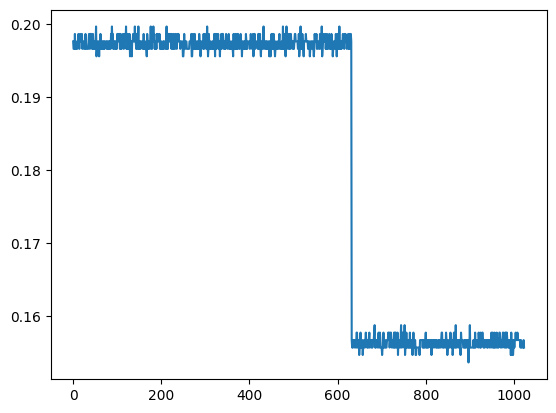

In [33]:
times = running_times(partial(dispatch_basic_lola, x, weights, bias, 128, 64, 32), 1024)
plt.plot(times)

In [20]:
_, gm = analyse_running_times(times)

In [30]:
gm.weights_

array([0.25298805, 0.74701195])

In [22]:
_

{0.1973084174791972: 750, 0.1564663906735698: 254}

In [24]:
np.sqrt(gm.covariances_)

array([[[0.00125083]],

       [[0.00128408]]])

(array([ 10.,   0.,  95.,   0., 119.,   0.,  36.,   0.,   0.,   4.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,  35.,   0.,   0., 279.,   0., 328.,   0., 104.,   0.,
         14.]),
 array([0.154624  , 0.15507456, 0.15552512, 0.15597568, 0.15642624,
        0.1568768 , 0.15732736, 0.15777792, 0.15822848, 0.15867904,
        0.1591296 , 0.15958016, 0.16003072, 0.16048128, 0.16093184,
        0.1613824 , 0.16183296, 0.16228352, 0.16273408, 0.16318464,
        0.1636352 , 0.16408576, 0.16453632, 0.

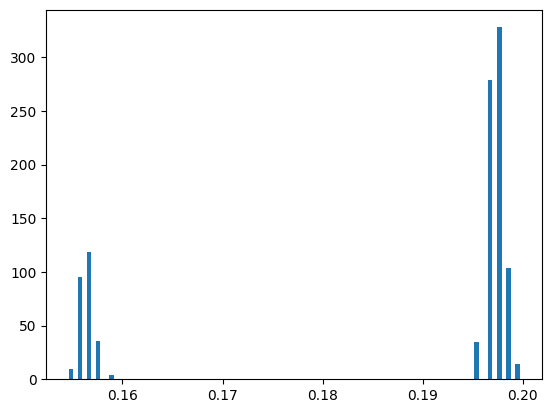

In [27]:
plt.hist(times, bins=100)

In [28]:
rtimes = np.array(times)
np.std(rtimes[rtimes > 0.18])

0.0008446050527353284

In [13]:
times1 = running_times(partial(dispatch_basic_lola, x, weights, bias, 128, 64, 32), 512)

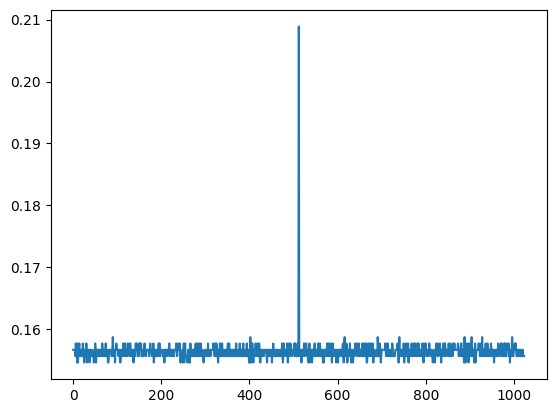

In [14]:
times2 = running_times(partial(dispatch_basic_lola, x, weights, bias, 128, 64, 32), 512)
plt.plot(times1 + times2)

In [15]:
analyse_running_times(times)[0]

{0.19711750433212374: 205, 0.15736662560097117: 799}

In [18]:
rtimes = np.sort(np.array(times))[10:-10]
for n_components in range(5):
    print(GaussianMixture(n_components=n_components + 1).fit(rtimes[:, None]).score(rtimes[:, None]))

NameError: name 'GaussianMixture' is not defined

In [ ]:
(4.9 - 2.6) / 2.6

0.8846153846153847

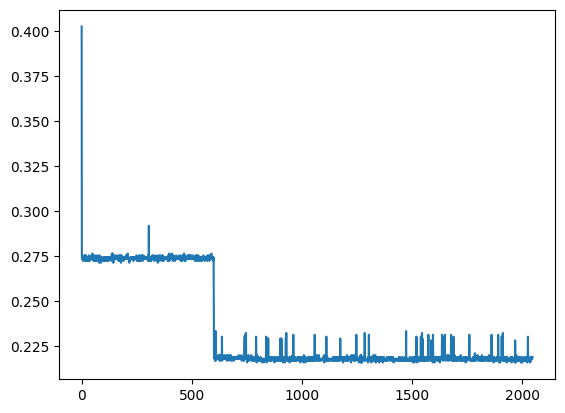

In [ ]:
times = running_times(partial(dispatch_basic_lola, x, weights, bias, 64, 64, 64), 2048)
plt.plot(times)

In [ ]:
analyse_running_times(times)[0]

{0.27383495518716716: 590, 0.2183826005964518: 1438}

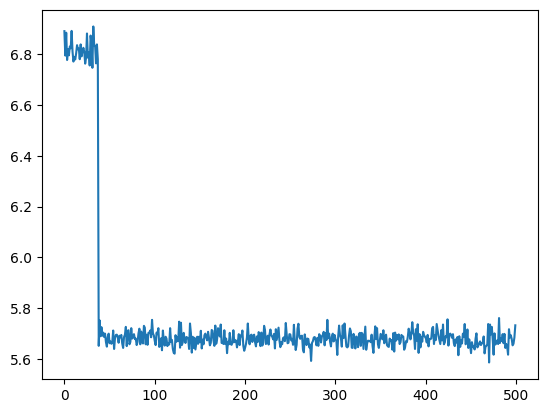

In [ ]:
times = running_times(partial(dispatch_basic_lola, x, weights, bias, 512, 64, 64), 500)
plt.plot(times)

In [ ]:
analyse_running_times(times)[0]

{5.745798394083977: 480}

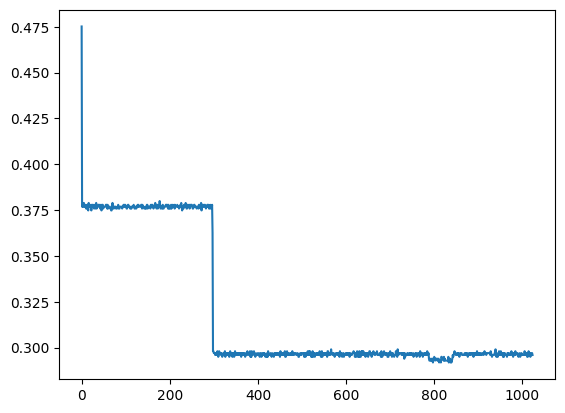

In [ ]:
times = running_times(lambda: torch_lola(x, weightsT, bias), 1024)
plt.plot(times)

In [ ]:
analyse_running_times(times)[0]

{0.37675733357254004: 288, 0.29621773858310124: 716}

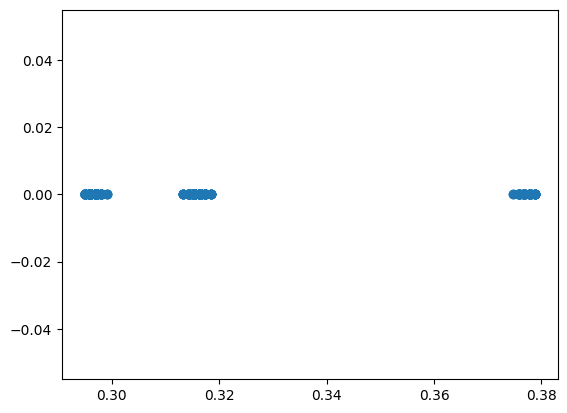

In [ ]:
rtimes = np.array(times)
rtimes = np.sort(rtimes)[10:-10]
plt.scatter(rtimes, [0] * len(rtimes))

In [ ]:
from sklearn.mixture import GaussianMixture

In [ ]:
gm = GaussianMixture(n_components=1).fit(rtimes[:, None])

In [ ]:
gm.means_, gm.covariances_

(array([[0.3179622]]), array([[[0.00078912]]]))

In [ ]:
gm.score(rtimes[:, None])

2.153990692147813

In [ ]:
gm.n_components

1

In [ ]:
gm2 = GaussianMixture(n_components=2).fit(rtimes[:, None])
gm2.means_, gm2.covariances_

(array([[0.30597978],
        [0.37716525]]),
 array([[[9.54940873e-05]],
 
        [[1.81341531e-06]]]))

In [ ]:
gm2.score(rtimes[:, None])

3.140438727069895

In [ ]:
gm3 = GaussianMixture(n_components=3).fit(rtimes[:, None])
gm3.means_, gm3.covariances_

(array([[0.3156923 ],
        [0.37716525],
        [0.2963368 ]]),
 array([[[1.98863676e-06]],
 
        [[1.81341531e-06]],
 
        [[1.68522632e-06]]]))

In [ ]:
gm3.score(rtimes[:, None])

4.4321192795887

In [ ]:
gm3.predict_proba(rtimes[:, None])

array([[1.17565632e-47, 0.00000000e+00, 1.00000000e+00],
       [1.17565632e-47, 0.00000000e+00, 1.00000000e+00],
       [1.17565632e-47, 0.00000000e+00, 1.00000000e+00],
       ...,
       [0.00000000e+00, 1.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 1.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 1.00000000e+00, 0.00000000e+00]])

In [ ]:
rtime_components = np.argmax(gm3.predict_proba(rtimes[:, None]), axis=1)

In [ ]:
rtime_components

array([2, 2, 2, ..., 1, 1, 1])

In [ ]:
mean_order = np.argsort(gm3.means_.flatten())
mean_order

array([2, 0, 1])

In [ ]:
rtime_components = mean_order[rtime_components]
rtime_components

array([0, 0, 0, ..., 2, 2, 2])

In [ ]:
rtimes_per_comp = np.unique(rtime_components, return_counts=True)[1]
rtimes_per_comp

array([419, 416, 169])

In [ ]:
{m: n_rtimes for m, n_rtimes in zip(gm3.means_.flatten()[mean_order], rtimes_per_comp)}

{0.29633679687265563: 419, 0.31569230355895483: 416, 0.3771652522877123: 169}

In [ ]:
gm3.means_.flatten()[mean_order]

array([0.2963368 , 0.3156923 , 0.37716525])

In [ ]:
gm4 = GaussianMixture(n_components=4).fit(rtimes[:, None])
gm4.means_, gm4.covariances_

(array([[0.3156923 ],
        [0.37716525],
        [0.29628745],
        [0.2964121 ]]),
 array([[[1.98863676e-06]],
 
        [[1.81341531e-06]],
 
        [[1.66460254e-06]],
 
        [[1.70731292e-06]]]))

In [ ]:
gm4.score(rtimes[:, None])

4.432138057058407

In [ ]:
import time
from typing import Callable, List


def get_running_times(fn: Callable, clear_cache_fn: Callable, n_repeats: int) -> List[float]:
    """
    Execute `fn` `n_repeats` times, and return a list of the running times (in ms).
    """

    start_events = [torch.cuda.Event(enable_timing=True) for i in range(n_repeats)]
    end_events = [torch.cuda.Event(enable_timing=True) for i in range(n_repeats)]

    for i in range(n_repeats):
        clear_cache_fn()
        start_events[i].record()
        fn()
        end_events[i].record()

    torch.cuda.synchronize()
    return [s.elapsed_time(e) for s, e in zip(start_events, end_events)]


def auto_bench(fn, tlimit: int = 1000):
    """
    Runtime benchmarking function inspired by Triton's `do_bench`, but benchmarks until
    a stable result is obtained, rather than requiring a `rep` parameter.

    Parameters
    ----------
    fn : callable
        Function to benchmark.
    tlimit : int
        Time limit for the benchmark (in ms).
    """
    # Execute once to make sure the function is jitted and everything is initialized.
    fn()
    torch.cuda.synchronize()

    cache = torch.empty(int(256e6 // 4), dtype=torch.int, device="cuda")
    clear_cache_fn = lambda: cache.zero_()

    bench_start = time.time()
    reps_per_set = 1
    times = []

    while True:
        now = time.time()
        if now - bench_start > tlimit / 1000:
            return times

        times += get_running_times(fn, clear_cache_fn, reps_per_set)
        
        reps_per_set *= 2

    

In [ ]:
from functools import partial
fn = partial(dispatch_basic_lola, x, weights, bias, 128, 64, 32)

In [ ]:
times = auto_bench(fn)

In [ ]:
len(times)

4095

In [ ]:
cache = torch.empty(int(256e6 // 4), dtype=torch.int, device="cuda")
clear_cache_fn = lambda: cache.zero_()

In [ ]:
import conch

In [ ]:
from matplotlib import pyplot as plt

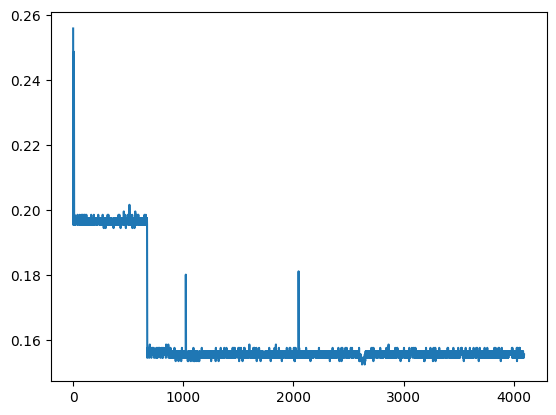

In [ ]:
plt.plot(times)

(array([6.10e+01, 7.00e+02, 1.66e+03, 8.78e+02, 1.16e+02, 6.00e+00,
        0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00,
        0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00,
        0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00,
        0.00e+00, 0.00e+00, 1.00e+00, 1.00e+00, 0.00e+00, 0.00e+00,
        0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00,
        0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 7.00e+00, 1.40e+02,
        3.48e+02, 1.42e+02, 3.00e+01, 2.00e+00, 0.00e+00, 1.00e+00,
        0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00,
        0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00,
        0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00,
        0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00,
        0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00,
        0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00,
        0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 

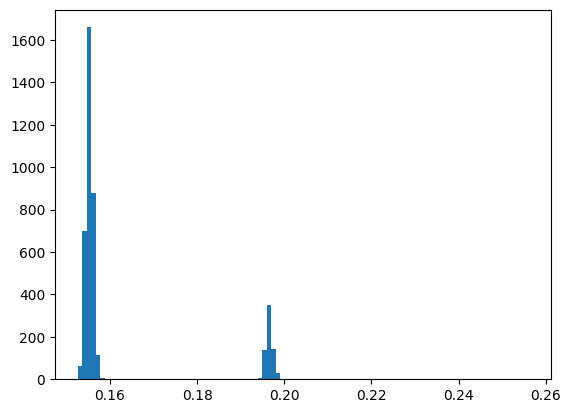

In [ ]:
plt.hist(times, bins=100)

In [ ]:
times[400]

0.19763199985027313

In [ ]:
times[512]

0.19763199985027313

In [ ]:
torch_fn = lambda: torch_lola(x, weightsT, bias)

torch_times = auto_bench(torch_fn)

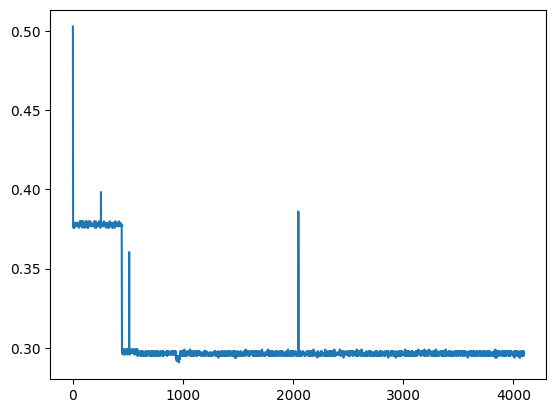

In [ ]:
plt.plot(torch_times)

(array([4.230e+02, 3.225e+03, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 4.250e+02, 1.700e+01, 1.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00]),
 array([0.29081601, 0.29505537, 0.29929473, 0.30353409, 0.30777345,
        0.31201281, 0.31625217, 0.32049153, 0.32473089, 0.32897025,
        0.33320961, 0.33744897, 0.34168833, 0.34592769, 0.35016705,
        0.35440641, 0.35864577, 0.36288513, 0.36712449, 0.37136385,
        0.37560321, 0.37984257, 0.38408193, 0.38832129, 0.39256065,
        0.39680001, 0.40103937, 0.40

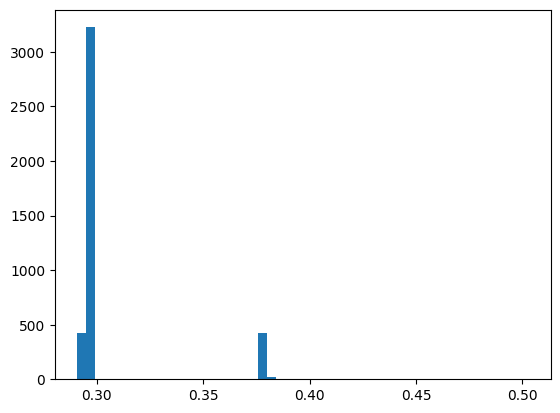

In [ ]:
plt.hist(torch_times, bins=50)

In [ ]:
from sklearn.mixture import GaussianMixture
import numpy as np

In [ ]:
def rm_outliers(arr):
    lo = np.percentile(arr, 5)
    hi = np.percentile(arr, 95)
    return arr[(arr > lo) & (arr < hi)]

In [ ]:
gm = GaussianMixture(n_components=2).fit(rm_outliers(np.array(times)).reshape(-1, 1))

In [ ]:
gm.means_

array([[0.15608223],
       [0.19533659]])

In [ ]:
gm.covariances_

array([[[1.36174625e-06]],

       [[3.95080550e-06]]])

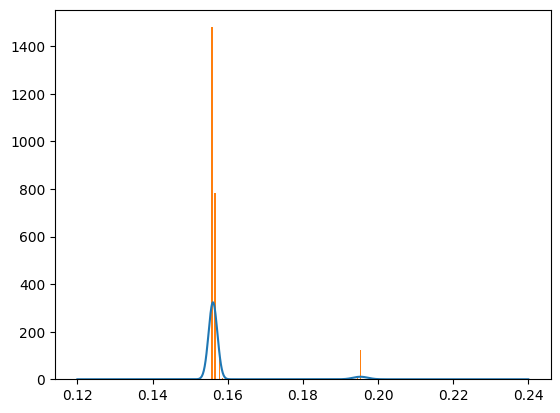

In [ ]:
plt.figure()
X = np.linspace(.12, .24, 1000)
plt.plot(X, np.exp(gm.score_samples(X.reshape(-1, 1))))
plt.hist(rm_outliers(np.array(times)), bins=100, density=True)
plt.show()

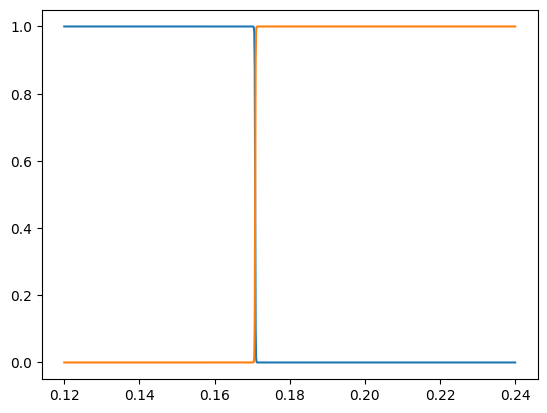

In [ ]:
plt.plot(X, (gm.predict_proba(X.reshape(-1, 1))))

In [ ]:
gm

GaussianMixture(n_components=2)

In [ ]:
1 + 2 + 4 + 8 + 16 + 32 + 64 + 128 + 256

511

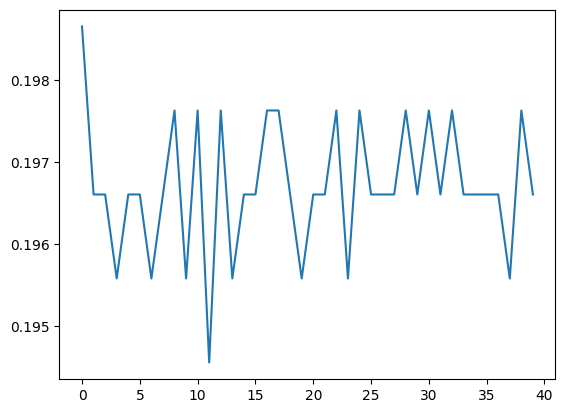

In [ ]:
plt.plot(times[420:460])

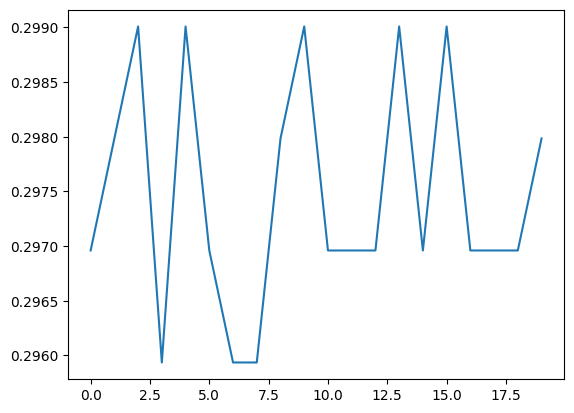

In [ ]:
plt.plot(torch_times[490:510])

In [ ]:
torch_times[500]

0.2969599962234497

In [ ]:
fn();

In [ ]:
from functools import partial
from triton.testing import do_bench

from conch import grid_search, PTXAnalyser

In [ ]:
%%script false --no-raise-error


v1_perf = grid_search(partial(dispatch_lola_v1, tx, tweights, tbias),
                      N_OCOLS=(16, 1024),
                      
                      N_BROWS=(16, 1024),
                      BLOCK_LEN=(16, 1024),
                      min_val_prod=50_000,)
v1_perf[:5]

In [ ]:
do_bench(partial(dispatch_lola_v1, tx, tweights, tbias, 128, 64, 32),
         warmup=100,
         rep=500)[0] * 1000


NameError: name 'dispatch_lola_v1' is not defined

In [ ]:
v1_pa = PTXAnalyser.FromKernel(kernel_lola_v1,
                               N_OCOLS=128,
                               N_BROWS=64,
                               BLOCK_LEN=32)

### Failed optimizations

During development of this kernel, I tried a bunch of things which ending up not working.

#### GELU vs fast GELU

The GELU activation function is defined as $\text{GELU}(x) = x \cdot \Phi(x) = x \cdot \frac{1}{2} \left(1 + \text{erf} \left(\frac{x}{\sqrt{2}}\right)\right)$ (where erf is [the error function](https://en.wikipedia.org/wiki/Error_function)). GELU is commonly approximated by $\text{GELU}(x) \approx 0.5 * x * (1 + \text{tanh}(\sqrt{\frac{2}{\pi}} * (x + 0.044715 * x^3)))$, however I found that using the approximation is actually slower than just using the exact GELU function. From examining the PTX code generated by the kernels, this happens because the CUDA implementations of `erf` and `tanh` are similar in speed, and the approximation is therefore slower because of the additional operations.

## Lola Kernel v2

Discussions on the Triton Github suggest that Triton kernels can perform poorly when multiple accmulators are used https://github.com/openai/triton/discussions/1186. We can remove one of our accumulators by computing the sum of weights ahead of time and passing this in as an argument to the kernel. 

Prior to testing this, I would have expected that re-computing the weight sum in the kernel would be faster than pre-computing and loading them in, since the re-computation has low arithmetic intensity, however the pre-computation does actually result in a significant performance increase.

Unfortunately we cannot apply the same trick to the embeddings `x`, since we are assuming that the kernel will be used in an inference setting, where the weights are fixed and the embeddings are changing.

In [ ]:
@triton.jit
def kernel_lola_v2(x_ptr, W_ptr, Ws_ptr, b_ptr, out_ptr, N_OCOLS: tl.constexpr,
                   N_BROWS: tl.constexpr, BLOCK_LEN: tl.constexpr,
                   N_FEAT_IN: tl.constexpr, N_FEAT_OUT: tl.constexpr):
    """
    Triton kernel implementing fused Layer nOrm, Linear and Activation.

    Kernel cell (i, j) computes:
    out[i * N_BROWS: (i+1) * N_BROWS, j * N_OCOLS: (j+1) * N_OCOLS].
    
    Iteration k of the inner loop computes:
    x[(i:i+1) * N_BROWS, (k:k+1) * BLOCK_LEN] @ W[(k:k+1) * BLOCK_LEN, (j:j+1) * N_OCOLS]

    Inputs
    ------
    x_ptr: [BATCH_SIZE, N_FEAT_IN] - input token embeddings.
    W_ptr: [N_FEAT_IN, N_FEAT_OUT] - linear layer weights.
    Ws_ptr: [N_FEAT_OUT,] - sum of the weights (in axis 0).
    b_ptr: [N_FEAT_OUT,] - linear layer bias.

    Outputs
    -------
    out_ptr: [N_FEAT_OUT,] - Lola output.
    
    Parameters
    ----------
    N_OCOLS - number of output columns computed per kernel instance.
    N_BROWS - number of batch elements (i.e. rows of `x`) computed per kernel instance.
    BLOCK_LEN - size of the block of `x` and `W` processed each iteration of the inner loop.
    N_FEAT_IN - number of input features.
    N_FEAT_OUT - number of output features.
    """
    # Each instance will process x[x_brow_start: x_brow_start + N_BROWS, :].
    x_brow_start = tl.program_id(0) * N_BROWS
    x_brow_idxs = tl.arange(0, N_BROWS) + x_brow_start

    # Each instance will compute out[<b-rows>, ocol_start: ocol_start + N_OCOLS].
    ocol_start = tl.program_id(1) * N_OCOLS
    ocol_idxs = tl.arange(0, N_OCOLS) + ocol_start

    # Initialize accumulators. We build up partial results while iterating over `x` and `W`.
    w_dot_x_acc = tl.zeros((N_BROWS, N_OCOLS), dtype=tl.float32)
    x_sum_acc = tl.zeros((N_BROWS, ), dtype=tl.float32)
    x_sq_sum_acc = tl.zeros((N_BROWS, ), dtype=tl.float32)

    # Iterate over N_FEAT_IN elements, in blocks of size BLOCK_LEN.
    n_blocks = tl.cdiv(N_FEAT_IN, BLOCK_LEN)
    for block_i in range(0, n_blocks):

        # Indices into the block dimension - columns of `x` and rows of `W`.
        block_idxs = tl.arange(0, BLOCK_LEN) + block_i * BLOCK_LEN

        # Load the current block of the input.
        x_block_idxs = x_brow_idxs[:, None] * N_FEAT_IN + block_idxs[None, :]
        x_block = tl.load(x_ptr + x_block_idxs)  # [N_BROWS, BLOCK_ROWS]

        W_block_idxs = block_idxs[:, None] * N_FEAT_OUT + ocol_idxs[None, :]
        W_block = tl.load(W_ptr + W_block_idxs)  # [BLOCK_ROWS, N_OCOLS]

        # Update the accumulators.
        # [N_BROWS, BLOCK_ROWS] @ [BLOCK_ROWS, N_OCOLS] -> [N_BROWS, N_OCOLS]
        w_dot_x_acc += tl.dot(x_block, W_block)
        x_sum_acc += tl.sum(x_block, axis=1)
        x_sq_sum_acc += tl.sum(x_block * x_block, axis=1)

    bias = tl.load(b_ptr + ocol_idxs)
    Wsum = tl.load(Ws_ptr + ocol_idxs)
    x_mean = x_sum_acc / N_FEAT_IN
    x_sq_mean = x_sq_sum_acc / N_FEAT_IN

    numer = w_dot_x_acc - x_mean[:, None] * Wsum[None, :]
    denom = tl.sqrt(tl.abs(x_sq_mean - x_mean * x_mean + 1e-5))
    out = gelu(numer / denom[:, None] + bias[None, :])

    out_idxs = x_brow_idxs[:, None] * N_FEAT_OUT + ocol_idxs[None, :]
    tl.store(out_ptr + out_idxs, out)

In [ ]:
def dispatch_lola_v2(
    x,
    W,
    Wsum,
    b,
    N_OCOLS: int,
    N_BROWS: int,
    BLOCK_LEN: int,
    num_warps=4,
    num_stages=1,
):
    assert N_BROWS >= 16 and BLOCK_LEN >= 16 and N_OCOLS >= 16, "Triton matrix multiplication requires matrix dimensions to be at least 16."

    N_BATCH = x.shape[0]
    N_FEAT_IN, N_FEAT_OUT = W.shape

    # Each instance processes `N_BROWS` of `x`, and `N_OCOLS` columns of `W`, so we need
    # `N_BATCH // N_BROWS * N_FEAT_OUT // N_OCOLS` instances.
    grid = (
        N_BATCH // N_BROWS,
        N_FEAT_OUT // N_OCOLS,
    )

    # Allocate output buffer.
    out = torch.zeros((N_BATCH, N_FEAT_OUT), dtype=x.dtype, device="cuda")

    # Launch the kernel.
    kernel_lola_v2[grid](x,
                         W,
                         Wsum,
                         b,
                         out,
                         N_OCOLS=N_OCOLS,
                         N_BROWS=N_BROWS,
                         BLOCK_LEN=BLOCK_LEN,
                         N_FEAT_IN=N_FEAT_IN,
                         N_FEAT_OUT=N_FEAT_OUT,
                         num_warps=num_warps,
                         num_stages=num_stages)

    return out

### Output comparison

In [ ]:
v2_out = dispatch_lola_v2(tx, tweights, tweights_sum, tbias, 128, 64, 32)
v2_out.shape

torch.Size([512, 4096])

In [ ]:
max_abs_diff(torch_out, v2_out)

0.003700018

### Performance tuning

In [ ]:
%%script false --no-raise-error

v2_perf = grid_search(partial(dispatch_lola_v2, tx, tweights, tweights_sum,
                              tbias),
                      N_OCOLS=(16, 1024),
                      N_BROWS=(16, 1024),
                      BLOCK_LEN=(16, 1024),
                      min_val_prod=50_000,
)
v2_perf[:5]

In [ ]:
do_bench(
    partial(dispatch_lola_v2, tx, tweights, tweights_sum, tbias, 128, 64, 32),
    100, 500)[0] * 1000


133.12000036239624

- Fast GELU: ` ({'N_OCOLS': 128, 'N_BROWS': 64, 'BLOCK_LEN': 32}, 130.048006772995),`
- No activation: `({'N_OCOLS': 128, 'N_BROWS': 64, 'BLOCK_LEN': 32}, 121.85599654912949)`
- Full GELU: `({'N_OCOLS': 128, 'N_BROWS': 64, 'BLOCK_LEN': 32}, 128.00000607967377),`


## Kernel v3

### Transposed Weights

In [ ]:
w = torch.arange(24).reshape(4, 6)
w

tensor([[ 0,  1,  2,  3,  4,  5],
        [ 6,  7,  8,  9, 10, 11],
        [12, 13, 14, 15, 16, 17],
        [18, 19, 20, 21, 22, 23]])

In [ ]:
w.T

tensor([[ 0,  6, 12, 18],
        [ 1,  7, 13, 19],
        [ 2,  8, 14, 20],
        [ 3,  9, 15, 21],
        [ 4, 10, 16, 22],
        [ 5, 11, 17, 23]])

In [ ]:
# attempt to select the block [[9, 10], [15, 16], [21, 22]] in both w and w.T

block_idxs = torch.tensor([1, 2, 3])
ocol_idxs = torch.tensor([3, 4])

W_block_idxs = block_idxs[:, None] * 6 + ocol_idxs[None, :]

W_block_idxs

tensor([[ 9, 10],
        [15, 16],
        [21, 22]])

In [ ]:
w.flatten()[W_block_idxs]

tensor([[ 9, 10],
        [15, 16],
        [21, 22]])

In [ ]:
Wt_block_idxs = ocol_idxs[None, :] * 4 + block_idxs[:, None]
Wt_block_idxs

tensor([[13, 17],
        [14, 18],
        [15, 19]])

In [ ]:
w.T.flatten()[Wt_block_idxs]

tensor([[ 9, 10],
        [15, 16],
        [21, 22]])

In [ ]:
tweights.shape, tweightsT.shape

(torch.Size([1024, 4096]), torch.Size([4096, 1024]))

In [ ]:
ocol_idxs = torch.arange(0, 4) + 12
block_idxs = torch.arange(0, 8) + 16
ocol_idxs, block_idxs

(tensor([12, 13, 14, 15]), tensor([16, 17, 18, 19, 20, 21, 22, 23]))

In [ ]:
N_FEAT_IN, N_FEAT_OUT = tweights.shape
N_FEAT_IN, N_FEAT_OUT

(1024, 4096)

In [ ]:
W_block_idxs = block_idxs[:, None] * N_FEAT_OUT + ocol_idxs[None, :]
W_block_idxs

tensor([[65548, 65549, 65550, 65551],
        [69644, 69645, 69646, 69647],
        [73740, 73741, 73742, 73743],
        [77836, 77837, 77838, 77839],
        [81932, 81933, 81934, 81935],
        [86028, 86029, 86030, 86031],
        [90124, 90125, 90126, 90127],
        [94220, 94221, 94222, 94223]])

In [ ]:
tweights.flatten()[W_block_idxs]

tensor([[ 0.0194,  0.0143, -0.0078, -0.0289],
        [ 0.0435, -0.0051,  0.0195,  0.0290],
        [ 0.0318,  0.0176, -0.0008,  0.0447],
        [-0.0306,  0.0089,  0.0175,  0.0062],
        [-0.0122,  0.0100,  0.0699,  0.0270],
        [-0.0278, -0.0342,  0.0610, -0.0172],
        [ 0.0528,  0.0565, -0.0195,  0.0314],
        [-0.0176, -0.0471,  0.0369,  0.0560]], device='cuda:0')

In [ ]:
Wt_block_idxs = ocol_idxs[None, :] * N_FEAT_IN + block_idxs[:, None]
Wt_block_idxs

tensor([[12304, 13328, 14352, 15376],
        [12305, 13329, 14353, 15377],
        [12306, 13330, 14354, 15378],
        [12307, 13331, 14355, 15379],
        [12308, 13332, 14356, 15380],
        [12309, 13333, 14357, 15381],
        [12310, 13334, 14358, 15382],
        [12311, 13335, 14359, 15383]])

In [ ]:
tweightsT.flatten()[Wt_block_idxs]

tensor([[ 0.0194,  0.0143, -0.0078, -0.0289],
        [ 0.0435, -0.0051,  0.0195,  0.0290],
        [ 0.0318,  0.0176, -0.0008,  0.0447],
        [-0.0306,  0.0089,  0.0175,  0.0062],
        [-0.0122,  0.0100,  0.0699,  0.0270],
        [-0.0278, -0.0342,  0.0610, -0.0172],
        [ 0.0528,  0.0565, -0.0195,  0.0314],
        [-0.0176, -0.0471,  0.0369,  0.0560]], device='cuda:0')

In [ ]:
@triton.jit
def kernel_lola_v3(x_ptr, Wt_ptr, Ws_ptr, b_ptr, out_ptr,
                   N_OCOLS: tl.constexpr, N_BROWS: tl.constexpr,
                   BLOCK_LEN: tl.constexpr, N_FEAT_IN: tl.constexpr,
                   N_FEAT_OUT: tl.constexpr):
    """
    Triton kernel implementing fused Layer nOrm, Linear and Activation.

    Kernel cell (i, j) computes:
    out[i * N_BROWS: (i+1) * N_BROWS, j * N_OCOLS: (j+1) * N_OCOLS].
    
    Iteration k of the inner loop computes:
    x[(i:i+1) * N_BROWS, (k:k+1) * BLOCK_LEN] @ W[(k:k+1) * BLOCK_LEN, (j:j+1) * N_OCOLS]

    Inputs
    ------
    x_ptr: [BATCH_SIZE, N_FEAT_IN] - input token embeddings.
    W_ptr: [N_FEAT_IN, N_FEAT_OUT] - linear layer weights.
    Ws_ptr: [N_FEAT_OUT,] - sum of the weights (in axis 0).
    b_ptr: [N_FEAT_OUT,] - linear layer bias.

    Outputs
    -------
    out_ptr: [N_FEAT_OUT,] - Lola output.
    
    Parameters
    ----------
    N_OCOLS - number of output columns computed per kernel instance.
    N_BROWS - number of batch elements (i.e. rows of `x`) computed per kernel instance.
    BLOCK_LEN - size of the block of `x` and `W` processed each iteration of the inner loop.
    N_FEAT_IN - number of input features.
    N_FEAT_OUT - number of output features.
    """
    # Each instance will process x[x_brow_start: x_brow_start + N_BROWS, :].
    x_brow_start = tl.program_id(0) * N_BROWS
    x_brow_idxs = tl.arange(0, N_BROWS) + x_brow_start

    # Each instance will compute out[<b-rows>, ocol_start: ocol_start + N_OCOLS].
    ocol_start = tl.program_id(1) * N_OCOLS
    ocol_idxs = tl.arange(0, N_OCOLS) + ocol_start

    # Initialize accumulators. We build up partial results while iterating over `x` and `W`.
    w_dot_x_acc = tl.zeros((N_BROWS, N_OCOLS), dtype=tl.float32)
    x_sum_acc = tl.zeros((N_BROWS, ), dtype=tl.float32)
    x_sq_sum_acc = tl.zeros((N_BROWS, ), dtype=tl.float32)

    # Iterate over N_FEAT_IN elements, in blocks of size BLOCK_LEN.
    n_blocks = tl.cdiv(N_FEAT_IN, BLOCK_LEN)
    for block_i in range(0, n_blocks):

        # Indices into the block dimension - columns of `x` and rows of `W`.
        block_idxs = tl.arange(0, BLOCK_LEN) + block_i * BLOCK_LEN

        # Load the current block of the input.
        x_block_idxs = x_brow_idxs[:, None] * N_FEAT_IN + block_idxs[None, :]
        x_block = tl.load(x_ptr + x_block_idxs)  # [N_BROWS, BLOCK_ROWS]

        # W_block_idxs = block_idxs[:, None] * N_FEAT_OUT + ocol_idxs[None, :]
        Wt_block_idxs = ocol_idxs[None, :] * N_FEAT_IN + block_idxs[:, None]
        W_block = tl.load(Wt_ptr + Wt_block_idxs)  # [BLOCK_ROWS, N_OCOLS]

        # Update the accumulators.
        # [N_BROWS, BLOCK_ROWS] @ [BLOCK_ROWS, N_OCOLS] -> [N_BROWS, N_OCOLS]
        w_dot_x_acc += tl.dot(x_block, W_block)
        x_sum_acc += tl.sum(x_block, axis=1)
        x_sq_sum_acc += tl.sum(x_block * x_block, axis=1)

    bias = tl.load(b_ptr + ocol_idxs)
    Wsum = tl.load(Ws_ptr + ocol_idxs)
    x_mean = x_sum_acc / N_FEAT_IN
    x_sq_mean = x_sq_sum_acc / N_FEAT_IN

    numer = w_dot_x_acc - x_mean[:, None] * Wsum[None, :]
    denom = tl.sqrt(tl.abs(x_sq_mean - x_mean * x_mean + 1e-5))
    # out = fast_gelu(numer / denom[:, None] + bias[None, :])
    out = numer / denom[:, None] + bias[None, :]
    out = gelu(out)

    out_idxs = x_brow_idxs[:, None] * N_FEAT_OUT + ocol_idxs[None, :]
    tl.store(out_ptr + out_idxs, out)

In [ ]:
def dispatch_lola_v3(
    x,
    Wt,
    Wsum,
    b,
    N_OCOLS: int,
    N_BROWS: int,
    BLOCK_LEN: int,
    num_warps=4,
    num_stages=1,
    output_buffer=None,
):
    assert N_BROWS >= 16 and BLOCK_LEN >= 16 and N_OCOLS >= 16, "Triton matrix multiplication requires matrix dimensions to be at least 16."

    assert N_BROWS >= 32, "Triton gives 'CUDA error: an illegal memory access was encountered' for N_BROWS = 16 - no idea why."

    N_BATCH = x.shape[0]
    N_FEAT_OUT, N_FEAT_IN = Wt.shape

    # Each instance processes `N_BROWS` of `x`, and `N_OCOLS` columns of `W`, so we need
    # `N_BATCH // N_BROWS * N_FEAT_OUT // N_OCOLS` instances.
    grid = (
        N_BATCH // N_BROWS,
        N_FEAT_OUT // N_OCOLS,
    )

    # Allocate output buffer.
    out = output_buffer if output_buffer is not None else torch.zeros(
        (N_BATCH, N_FEAT_OUT), dtype=x.dtype, device="cuda")

    # Launch the kernel.
    kernel_lola_v3[grid](x,
                         Wt,
                         Wsum,
                         b,
                         out,
                         N_OCOLS=N_OCOLS,
                         N_BROWS=N_BROWS,
                         BLOCK_LEN=BLOCK_LEN,
                         N_FEAT_IN=N_FEAT_IN,
                         N_FEAT_OUT=N_FEAT_OUT,
                         num_warps=num_warps,
                         num_stages=num_stages)

    return out

### Output comparison

In [ ]:
v3_out = dispatch_lola_v3(tx, tweightsT, tweights_sum, tbias, 128, 64, 32)

In [ ]:
max_abs_diff(torch_out, v3_out)

0.003700018

In [ ]:
%%script false --no-raise-error

v3_perf = grid_search(partial(dispatch_lola_v3, tx, tweightsT, tweights_sum,
                              tbias),
                      N_OCOLS=(16, 1024),
                      N_BROWS=(32, 1024),
                      BLOCK_LEN=(16, 1024),
                      min_val_prod=50_000,
                      do_print=True)

v3_perf[:5]

In [ ]:
do_bench(
    partial(dispatch_lola_v3, tx, tweightsT, tweights_sum, tbias, 128, 64, 32),
    100, 500)[0] * 1000


129.02399897575378

## Kernel v4 - Grouping instances

`TODO:` use swizzle2d instead: https://github.com/openai/triton/search?q=swizzle2d&type=code

The [Triton matrix multiplication tutorial](https://triton-lang.org/master/getting-started/tutorials/03-matrix-multiplication.html) suggests that it is possible to improve performance by having successive kernel instances read from the same memory locations. This makes best use of the GPUs L2 cache, which is shared between all SMs.

To do instance grouping, we introduce a new meta-parameter `GROUP_LEN`, which is the side length of a group, measured in instances/blocks. The `N_FEAT_OUT` axis is divided into `N_FEAT_OUT / N_OCOLS` blocks, and therefore into `group_len_f = N_FEAT_OUT / N_OCOLS / GROUP_LEN` groups. Previously the kernel did not need to know the batch size, because this was implicit in the number of instances. Now the kernel needs a `BATCH_SIZE` meta-parameter, for grouping calculations. The `BATCH_SIZE` axis is divided into `BATCH_SIZE / N_BROWS` blocks, and therefore into `group_len_b = BATCH_SIZE / N_BROWS / GROUP_LEN` groups.

We therefore have a total of `n_groups = group_len_f * group_len_b` groups, each consisting of `group_size = GROUP_LEN * GROUP_LEN` blocks/instances.

We launch a 1D grid of `BATCH_LEN // N_BROWS * N_FEAT_OUT // N_OCOLS` instances. Instance `n` is in group `group_num = n // group_size`, and is the `gmem_num = n % group_size`^th instance in that group.

For a column-major group order, group `group_num` has group coordinates `(s, t)`, where `s = group_num % group_len_b` and `t = group_num // group_len_b`.

Within group `group_num`, instance `gmem_num` has overall instance coordinates `(i, j)`. Where `i = s * GROUP_LEN + gmem_num % GROUP_LEN` and `j = t * GROUP_LEN + gmem_num // GROUP_LEN`.

In [ ]:
BATCH_SIZE = 512
N_OCOLS = 128
N_BROWS = 64
GROUP_LEN = 2
N_FEAT_OUT = 4096

for inst_n in range(BATCH_SIZE // N_BROWS * N_FEAT_OUT // N_OCOLS):
    # Num groups in out axis 0 (batch axis).
    GROUP_LEN_B = BATCH_SIZE // N_BROWS // GROUP_LEN
    # Num groups in out axis 1 (feature axis).
    GROUP_LEN_F = N_FEAT_OUT // N_OCOLS // GROUP_LEN
    N_GROUPS = GROUP_LEN_B * GROUP_LEN_F

    # inst_n = tl.program_id(0) # Index of this instance in the launch grid.
    inst_gn = inst_n % GROUP_LEN  # Index of this instance in it's group's instance grid.
    group_n = inst_n // GROUP_LEN  # Index of this instance's group.
    # Coordinates of this group in the group grid.
    s = group_n % GROUP_LEN_B
    t = group_n // GROUP_LEN_B

    # Coordinates of this instance in the instance grid.
    i = s * GROUP_LEN + inst_gn % GROUP_LEN
    j = t * GROUP_LEN + inst_gn // GROUP_LEN

    print(i, j)

0 0
1 0
2 0
3 0
4 0
5 0
6 0
7 0
0 2
1 2
2 2
3 2
4 2
5 2
6 2
7 2
0 4
1 4
2 4
3 4
4 4
5 4
6 4
7 4
0 6
1 6
2 6
3 6
4 6
5 6
6 6
7 6
0 8
1 8
2 8
3 8
4 8
5 8
6 8
7 8
0 10
1 10
2 10
3 10
4 10
5 10
6 10
7 10
0 12
1 12
2 12
3 12
4 12
5 12
6 12
7 12
0 14
1 14
2 14
3 14
4 14
5 14
6 14
7 14
0 16
1 16
2 16
3 16
4 16
5 16
6 16
7 16
0 18
1 18
2 18
3 18
4 18
5 18
6 18
7 18
0 20
1 20
2 20
3 20
4 20
5 20
6 20
7 20
0 22
1 22
2 22
3 22
4 22
5 22
6 22
7 22
0 24
1 24
2 24
3 24
4 24
5 24
6 24
7 24
0 26
1 26
2 26
3 26
4 26
5 26
6 26
7 26
0 28
1 28
2 28
3 28
4 28
5 28
6 28
7 28
0 30
1 30
2 30
3 30
4 30
5 30
6 30
7 30
0 32
1 32
2 32
3 32
4 32
5 32
6 32
7 32
0 34
1 34
2 34
3 34
4 34
5 34
6 34
7 34
0 36
1 36
2 36
3 36
4 36
5 36
6 36
7 36
0 38
1 38
2 38
3 38
4 38
5 38
6 38
7 38
0 40
1 40
2 40
3 40
4 40
5 40
6 40
7 40
0 42
1 42
2 42
3 42
4 42
5 42
6 42
7 42
0 44
1 44
2 44
3 44
4 44
5 44
6 44
7 44
0 46
1 46
2 46
3 46
4 46
5 46
6 46
7 46
0 48
1 48
2 48
3 48
4 48
5 48
6 48
7 48
0 50
1 50
2 50
3 50
4 50
5 50
6 50
7 50


In [ ]:
@triton.jit
def kernel_lola_v4(x_ptr, Wt_ptr, Ws_ptr, b_ptr, out_ptr,
                   N_OCOLS: tl.constexpr, N_BROWS: tl.constexpr,
                   BLOCK_LEN: tl.constexpr, GROUP_LEN: tl.constexpr,
                   N_FEAT_IN: tl.constexpr, N_FEAT_OUT: tl.constexpr,
                   BATCH_SIZE: tl.constexpr):
    """
    Triton kernel implementing fused Layer nOrm, Linear and Activation.

    Kernel cell (i, j) computes:
    out[i * N_BROWS: (i+1) * N_BROWS, j * N_OCOLS: (j+1) * N_OCOLS].
    
    Iteration k of the inner loop computes:
    x[(i:i+1) * N_BROWS, (k:k+1) * BLOCK_LEN] @ W[(k:k+1) * BLOCK_LEN, (j:j+1) * N_OCOLS]

    Inputs
    ------
    x_ptr: [BATCH_SIZE, N_FEAT_IN] - input token embeddings.
    W_ptr: [N_FEAT_IN, N_FEAT_OUT] - linear layer weights.
    Ws_ptr: [N_FEAT_OUT,] - sum of the weights (in axis 0).
    b_ptr: [N_FEAT_OUT,] - linear layer bias.

    Outputs
    -------
    out_ptr: [N_FEAT_OUT,] - Lola output.
    
    Parameters
    ----------
    N_OCOLS - number of output columns computed per kernel instance.
    N_BROWS - number of batch elements (i.e. rows of `x`) computed per kernel instance.
    BLOCK_LEN - size of the block of `x` and `W` processed each iteration of the inner loop.
    GROUP_LEN - number of blocks/instances per group in the `N_FEAT_OUT` axis.
    N_FEAT_IN - number of input features.
    N_FEAT_OUT - number of output features.
    BATCH_SIZE - number of batch elements - i.e. `x.shape[0]`.
    """
    # Num groups in out axis 0 (batch axis).
    GROUP_LEN_B = BATCH_SIZE // N_BROWS // GROUP_LEN
    # Num groups in out axis 1 (feature axis).
    GROUP_LEN_F = N_FEAT_OUT // N_OCOLS // GROUP_LEN
    N_GROUPS = GROUP_LEN_B * GROUP_LEN_F

    inst_n = tl.program_id(0)  # Index of this instance in the launch grid.
    inst_gn = inst_n % GROUP_LEN  # Index of this instance in it's group's instance grid.
    group_n = inst_n // GROUP_LEN  # Index of this instance's group.
    # Coordinates of this group in the group grid.
    s = group_n % GROUP_LEN_B
    t = group_n // GROUP_LEN_B

    # Coordinates of this instance in the instance grid.
    i = s * GROUP_LEN + inst_gn % GROUP_LEN
    j = t * GROUP_LEN + inst_gn // GROUP_LEN

    # Each instance will process x[x_brow_start: x_brow_start + N_BROWS, :].
    x_brow_start = i * N_BROWS
    x_brow_idxs = tl.arange(0, N_BROWS) + x_brow_start

    # Each instance will compute out[<b-rows>, ocol_start: ocol_start + N_OCOLS].
    ocol_start = j * N_OCOLS
    ocol_idxs = tl.arange(0, N_OCOLS) + ocol_start

    # Initialize accumulators. We build up partial results while iterating over `x` and `W`.
    w_dot_x_acc = tl.zeros((N_BROWS, N_OCOLS), dtype=tl.float32)
    x_sum_acc = tl.zeros((N_BROWS, ), dtype=tl.float32)
    x_sq_sum_acc = tl.zeros((N_BROWS, ), dtype=tl.float32)

    # Iterate over N_FEAT_IN elements, in blocks of size BLOCK_LEN.
    n_blocks = tl.cdiv(N_FEAT_IN, BLOCK_LEN)
    for block_i in range(0, n_blocks):

        # Indices into the block dimension - columns of `x` and rows of `W`.
        block_idxs = tl.arange(0, BLOCK_LEN) + block_i * BLOCK_LEN

        # Load the current block of the input.
        x_block_idxs = x_brow_idxs[:, None] * N_FEAT_IN + block_idxs[None, :]
        x_block = tl.load(x_ptr + x_block_idxs)  # [N_BROWS, BLOCK_ROWS]

        # W_block_idxs = block_idxs[:, None] * N_FEAT_OUT + ocol_idxs[None, :]
        Wt_block_idxs = ocol_idxs[None, :] * N_FEAT_IN + block_idxs[:, None]
        W_block = tl.load(Wt_ptr + Wt_block_idxs)  # [BLOCK_ROWS, N_OCOLS]

        # Update the accumulators.
        # [N_BROWS, BLOCK_ROWS] @ [BLOCK_ROWS, N_OCOLS] -> [N_BROWS, N_OCOLS]
        w_dot_x_acc += tl.dot(x_block, W_block)
        x_sum_acc += tl.sum(x_block, axis=1)
        x_sq_sum_acc += tl.sum(x_block * x_block, axis=1)

    bias = tl.load(b_ptr + ocol_idxs)
    Wsum = tl.load(Ws_ptr + ocol_idxs)
    x_mean = x_sum_acc / N_FEAT_IN
    x_sq_mean = x_sq_sum_acc / N_FEAT_IN

    numer = w_dot_x_acc - x_mean[:, None] * Wsum[None, :]
    denom = tl.sqrt(tl.abs(x_sq_mean - x_mean * x_mean + 1e-5))
    out = numer / denom[:, None] + bias[None, :]
    out = gelu(out)

    out_idxs = x_brow_idxs[:, None] * N_FEAT_OUT + ocol_idxs[None, :]
    tl.store(out_ptr + out_idxs, out)

In [ ]:
def dispatch_lola_v4(
    x,
    Wt,
    Wsum,
    b,
    N_OCOLS: int,
    N_BROWS: int,
    BLOCK_LEN: int,
    GROUP_LEN: int,
    num_warps=4,
    num_stages=1,
    output_buffer=None,
):
    assert N_BROWS >= 16 and BLOCK_LEN >= 16 and N_OCOLS >= 16, "Triton matrix multiplication requires matrix dimensions to be at least 16."

    assert N_BROWS >= 32, "Triton gives 'CUDA error: an illegal memory access was encountered' for N_BROWS = 16 - no idea why."

    N_BATCH = x.shape[0]
    N_FEAT_OUT, N_FEAT_IN = Wt.shape

    # Each instance processes `N_BROWS` of `x`, and `N_OCOLS` columns of `W`, so we need
    # `N_BATCH // N_BROWS * N_FEAT_OUT // N_OCOLS` instances.
    grid = (N_BATCH // N_BROWS * N_FEAT_OUT // N_OCOLS, )

    # Allocate output buffer.
    out = output_buffer if output_buffer is not None else torch.zeros(
        (N_BATCH, N_FEAT_OUT), dtype=x.dtype, device="cuda")

    # Launch the kernel.
    kernel_lola_v4[grid](x,
                         Wt,
                         Wsum,
                         b,
                         out,
                         N_OCOLS=N_OCOLS,
                         N_BROWS=N_BROWS,
                         BLOCK_LEN=BLOCK_LEN,
                         GROUP_LEN=GROUP_LEN,
                         N_FEAT_IN=N_FEAT_IN,
                         N_FEAT_OUT=N_FEAT_OUT,
                         BATCH_SIZE=N_BATCH,
                         num_warps=num_warps,
                         num_stages=num_stages)

    return out

In [ ]:
v4_out = dispatch_lola_v4(tx, tweightsT, tweights_sum, tbias, 128, 64, 32, 2)

In [ ]:
v4_out

tensor([[ 0.1188,  0.8314, -0.1480,  ...,  0.0000,  0.0000,  0.0000],
        [24.2482, -0.0000,  9.0225,  ...,  0.0000,  0.0000,  0.0000],
        [-0.0000, -0.0000, 17.0816,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 9.3048, -0.0000,  9.0300,  ...,  0.0000,  0.0000,  0.0000],
        [ 4.0409, 12.1864, -0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 5.6562, 50.9876, 34.1517,  ...,  0.0000,  0.0000,  0.0000]],
       device='cuda:0')

In [ ]:
v3_out

tensor([[ 0.1188,  0.8314, -0.1480,  ..., -0.1545,  1.5652, -0.0289],
        [ 0.7051,  0.4896, -0.0143,  ...,  0.8839,  1.4435, -0.0991],
        [-0.1548,  1.2149,  1.8963,  ...,  0.1322,  0.0165,  0.6485],
        ...,
        [-0.1095,  0.1516,  0.1929,  ...,  0.9809, -0.0920,  1.8368],
        [-0.0041,  2.5546,  1.3898,  ..., -0.0805,  1.4289, -0.1637],
        [ 0.7801,  0.0602, -0.1422,  ...,  1.3162,  0.9067,  0.2827]],
       device='cuda:0')

# CUDA Graphs

<img src="https://pytorch.org/assets/images/cuda-image-2.png" height="200px"/>

CUDA graphs can be used to speed up both Triton kernels and native PyTorch code. This is done by eliding the time spent on the CPU dispatching Triton kernels or PyTorch operations. To use CUDA graphs to speed up a function, we first instantiate PyTorch tensors to act as buffers for the function's inputs and outputs. We then set the graph to start recording GPU operations, call the function, then end the recording. The CUDA graph records the GPU operations which were performed on the input and output tensors - i.e. which CUDA kernels were invoked with which arguments etc. We can 'replay' the graph to execute the exact same sequence of operations again. The magic is that by copying new data into the functions 'input buffer tensor', replaying the graph will produce a new output!

The speed up comes from the fact that the CUDA graph is stored entirely on the GPU, meaning that once the graph starts replaying, no further communications between the CPU and GPU occur until the graph has finished. The GPU is free to execute the entire sequence of operations independently.

Even though our Triton kernel is a single CUDA kernel, we still see a small performance increase from CUDA graphs, since CUDA graphs remove the Triton overhead of dispatching the kernel. This overhead involves, for example, checking the dtypes and shapes of the input tensors and searching the compile cache for a matching compiled kernel.

## Lola Triton Kernel

In this section we apply CUDA Graphs to achieve a small performance increase in our Triton kernel.

In [ ]:
# Output buffer for the graph. The graph will always write its results into this tensor.
static_target = torch.zeros_like(torch_out)

# Function used to generate the graph. `x` would usually be a parameter to f, but for
# testing all parameters are fixed.
f = lambda: dispatch_lola_v3(tx,
                             tweightsT,
                             tweights_sum,
                             tbias,
                             128,
                             64,
                             32,
                             output_buffer=static_target)

# Warmup - the PyTorch docs recommend running the target function a couple of times on
# a new cuda stream, before creating the graph.
# See: https://pytorch.org/blog/accelerating-pytorch-with-cuda-graphs/#api-example
s = torch.cuda.Stream()
s.wait_stream(torch.cuda.current_stream())
with torch.cuda.stream(s):
    for _ in range(3):
        f()
torch.cuda.current_stream().wait_stream(s)

# Create the graph. While inside the `torch.cuda.graph()` context manager, all CUDA
# operations are recording to the graph (instead of being executed).
lk_cg = torch.cuda.CUDAGraph()
with torch.cuda.graph(lk_cg):
    f()

# At this point, `lk_cg.replay()` will re-run the same operations as `f()`, and store the
# results in `static_output`.

### Testing the Graph

We test the graph by zero-ing out the output tensor, then replaying the graph. After replaying, the output tensor should contain the correct kernel results:

In [ ]:
static_target.zero_()
static_target

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0')

In [ ]:
lk_cg.replay()

In [ ]:
static_target

tensor([[ 0.1188,  0.8314, -0.1480,  ..., -0.1545,  1.5652, -0.0289],
        [ 0.7051,  0.4896, -0.0143,  ...,  0.8839,  1.4435, -0.0991],
        [-0.1548,  1.2149,  1.8963,  ...,  0.1322,  0.0165,  0.6485],
        ...,
        [-0.1095,  0.1516,  0.1929,  ...,  0.9809, -0.0920,  1.8368],
        [-0.0041,  2.5546,  1.3898,  ..., -0.0805,  1.4289, -0.1637],
        [ 0.7801,  0.0602, -0.1422,  ...,  1.3162,  0.9067,  0.2827]],
       device='cuda:0')

In [ ]:
max_abs_diff(torch_out, static_target)

0.003700018

### Benchmarking

The CUDA Graph has improved running time from 128 us to 127 us. This is not a huge improvement, but note that Triton's overhead is likely fairly constant, so this improvement could be quite significant for smaller kernels.

In [ ]:
do_bench(lk_cg.replay, 100, 500)[0] * 1000

126.97599828243256

## `torch_lola`

In [ ]:
s = torch.cuda.Stream()
s.wait_stream(torch.cuda.current_stream())
with torch.cuda.stream(s):
    for _ in range(3):
        static_target = torch_lola(tx, tweightsT, tbias)
torch.cuda.current_stream().wait_stream(s)

tl_cg = torch.cuda.CUDAGraph()
with torch.cuda.graph(tl_cg):
    static_target = torch_lola(tx, tweightsT, tbias)

### Testing the Graph

In [ ]:
static_target.zero_()
static_target

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0')

In [ ]:
tl_cg.replay()

In [ ]:
static_target

tensor([[ 0.1190,  0.8321, -0.1480,  ..., -0.1544,  1.5669, -0.0290],
        [ 0.7054,  0.4894, -0.0142,  ...,  0.8848,  1.4450, -0.0990],
        [-0.1547,  1.2157,  1.8975,  ...,  0.1324,  0.0163,  0.6489],
        ...,
        [-0.1093,  0.1518,  0.1928,  ...,  0.9820, -0.0921,  1.8379],
        [-0.0041,  2.5562,  1.3911,  ..., -0.0806,  1.4301, -0.1636],
        [ 0.7808,  0.0597, -0.1422,  ...,  1.3169,  0.9079,  0.2830]],
       device='cuda:0')

In [ ]:
max_abs_diff(torch_out, static_target)

0.0

### Benchmarking

In [ ]:
do_bench(lambda: torch_lola(tx, tweightsT, tbias), 100, 500)[0] * 1000

297.9840040206909

In [ ]:
do_bench(tl_cg.replay, 100, 500)[0] * 1000

300.03198981285095

# Future Work

## Reduced-precision operations

All the analysis so far has been done using ordinary 32-bit floats (except that `tl.dot` may use [tfloat32](https://blogs.nvidia.com/blog/2020/05/14/tensorfloat-32-precision-format/) to hold intermediate values). We could likely gain performance at the cost of some accuracy by using float16 or bfloat16, for some or all of the weights, embeddings or intermediate values in the kernels. Using integer types such as int8 is another possibility. The main reason I have left this off the table for now, is that Triton support for non-float32 data types is still of a work in progress. At the time of writing, there is an [open Triton PR adding support for float16/bfloat16 `tl.dot` output](https://github.com/openai/triton/pull/1258)

# Benchmarking

In [ ]:
from triton.testing import do_bench

# We use `do_bench` for both triton and pytorch, for fairness. `do_bench` does things like clearing the l2 cache, which %%timeit doesn't

In [ ]:
do_bench(partial(torch_lola, tx, tweightsT, tbias), warmup=100,
         rep=250)[0] * 1000


296.9599962234497

In [ ]:
cg_torch_lola = torch.compile(lambda x: torch_lola(x, tweightsT, tbias),
                              mode="reduce-overhead")
do_bench(lambda: cg_torch_lola(tx), warmup=100, rep=250)[0] * 1000

/opt/conda/lib/python3.10/site-packages/torch/_inductor/compile_fx.py:93: UserWarning: TensorFloat32 tensor cores for float32 matrix multiplication available but not enabled. Consider setting `torch.set_float32_matmul_precision('high')` for better performance.
  warnings.warn(


335.87199449539185

In [ ]:
cg = torch.cuda.CUDAGraph()

static_target = torch.zeros_like(torch_out)

with torch.cuda.graph(cg):
    cg_out = torch_lola(tx, tweightsT, tbias)
    static_target.copy_(cg_out)

In [ ]:
static_target

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0')

In [ ]:
kcg = torch.cuda.CUDAGraph()

static_target = torch.zeros_like(torch_out)

with torch.cuda.graph(kcg):
    dispatch_lola_v3(tx,
                     tweightsT,
                     tweights_sum,
                     tbias,
                     128,
                     64,
                     32,
                     output_buffer=static_target)


In [ ]:
static_target

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0')

In [ ]:
%%timeit -n1000

kcg.replay()

123 µs ± 16.2 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [ ]:
max_abs_diff(torch_out, static_target)

0.003700018

In [ ]:
do_bench(cg.replay, warmup=100, rep=500)[0] * 1000


309.2480003833771

In [ ]:
do_bench(kcg.replay, warmup=100, rep=500)[0] * 1000


126.97599828243256

In [ ]:
%%timeit -n1000

kcg.replay()

116 µs ± 14.5 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [ ]:
kcg.replay??

Signature: kcg.replay()
Source:   
    def replay(self):
        r"""
        Replays the CUDA work captured by this graph.
        """
        super().replay()
File:      /opt/conda/lib/python3.10/site-packages/torch/cuda/graphs.py
Type:      method

In [ ]:
with torch.no_grad():
    torch_gc = torch.cuda.make_graphed_callables(torch_lola,
                                                 (tx, tweightsT, tbias))


ValueError: grad requires non-empty inputs.

In [ ]:
do_bench(partial(dispatch_lola_v3, tx, tweightsT, tweights_sum, tbias, 128, 64,
                 32),
         warmup=100,
         rep=500)[0] * 1000


128.00000607967377

In [ ]:
dispatch_lola_v3(tx, tweightsT, tweights_sum, tbias, 128, 64, 32)

tensor([[ 0.1188,  0.8314, -0.1480,  ..., -0.1545,  1.5652, -0.0289],
        [ 0.7051,  0.4896, -0.0143,  ...,  0.8839,  1.4435, -0.0991],
        [-0.1548,  1.2149,  1.8963,  ...,  0.1322,  0.0165,  0.6485],
        ...,
        [-0.1095,  0.1516,  0.1929,  ...,  0.9809, -0.0920,  1.8368],
        [-0.0041,  2.5546,  1.3898,  ..., -0.0805,  1.4289, -0.1637],
        [ 0.7801,  0.0602, -0.1422,  ...,  1.3162,  0.9067,  0.2827]],
       device='cuda:0')

In [ ]:
v2_pa = PTXAnalyser.FromKernel(kernel_lola_v2,
                               N_OCOLS=128,
                               N_BROWS=64,
                               BLOCK_LEN=32)


In [ ]:
v3_pa = PTXAnalyser.FromKernel(kernel_lola_v3,
                               N_OCOLS=128,
                               N_BROWS=64,
                               BLOCK_LEN=32)


In [ ]:
with open('cubin.bin', 'wb') as f:
    f.write(v3_pa.kernel_asm["cubin"])

In [ ]:
v3_pa.op_counts

Counter({'mov.f32': 1044,
         'fma.rn.ftz.f32': 455,
         'mov.b32': 435,
         'mul.f32': 194,
         'add.f32': 156,
         'bra': 131,
         'div.full.f32': 130,
         'or.b32': 95,
         'and.b32': 80,
         'fma.rn.f32': 80,
         'add.s32': 78,
         'neg.f32': 70,
         'setp.ge.f32': 66,
         'sub.f32': 66,
         'selp.f32': 66,
         'abs.ftz.f32': 65,
         'setp.ltu.f32': 65,
         'ex2.approx.ftz.f32': 65,
         'mma.sync.aligned.m16n8k8.row.col.f32.tf32.tf32.f32': 64,
         'ld.shared.f32': 60,
         'shl.b32': 38,
         'st.shared.v2.f32': 32,
         'add.s64': 31,
         'mul.wide.s32': 29,
         'bar.sync': 26,
         'ldmatrix.sync.aligned.m8n8.x4.shared.b16': 24,
         'st.shared.u32': 19,
         'ld.shared.v4.u32': 16,
         'st.global.v4.b32': 16,
         'ld.global.v4.b32': 12,
         'shfl.sync.bfly.b32': 12,
         'xor.b32': 10,
         'st.shared.v4.u32': 8,
         'st.sha

In [ ]:
print(v3_pa.summarize_ptx())

// 
// Generated by LLVM NVPTX Back-End 
// 
 
.version 8.0 
.target sm_80 
.address_size 64 
 
	// .globl	kernel_lola_v3_0d1d2d3d4d 
.extern .shared .align 1 .b8 global_smem[]; 
.global .align 1 .b8 _$_str[11] = {95, 95, 67, 85, 68, 65, 95, 70, 84, 90, 0}; 
.global .align 1 .b8 _$_str_$_2[17] = {95, 95, 67, 85, 68, 65, 95, 80, 82, 69, 67, 95, 83, 81, 82, 84, 0}; 
 
.visible .entry kernel_lola_v3_0d1d2d3d4d( 
	.param .u64 kernel_lola_v3_0d1d2d3d4d_param_0, 
	.param .u64 kernel_lola_v3_0d1d2d3d4d_param_1, 
	.param .u64 kernel_lola_v3_0d1d2d3d4d_param_2, 
	.param .u64 kernel_lola_v3_0d1d2d3d4d_param_3, 
	.param .u64 kernel_lola_v3_0d1d2d3d4d_param_4 
) 
.maxntid 128, 1, 1 
{ 
	.reg .pred 	%p<231>; 
	.reg .b16 	%rs<3>; 
	.reg .b32 	%r<1560>; 
	.reg .f32 	%f<4508>; 
	.reg .b64 	%rd<69>; 
 
	ld.param.u64 	%rd7, [kernel_lola_v3_0d1d2d3d4d_param_4]; 
	ld.param.u64 	%rd6, [kernel_lola_v3_0d1d2d3d4d_param_3]; 
	ld.param.u64 	%rd5, [kernel_lola_v3_0d1d2d3d4d_param_2]; 
	ld.param.u64 	%rd4, [kern

In [ ]:
import more_itertools
from collections import Counter

In [ ]:
Counter(more_itertools.substrings(v1_pa.op_names))

KeyboardInterrupt: 

In [ ]:
v1_pa.op_counts - v2_pa.op_counts

Counter({'mov.b32': 32,
         'add.f32': 40,
         'ld.shared.f32': 32,
         'or.b32': 1,
         'mov.f32': 4,
         'add.s32': 12,
         'shl.b32': 1,
         'bar.sync': 18,
         'st.shared.f32': 16,
         'st.shared.v4.f32': 8,
         'selp.b32': 2,
         'setp.eq.s32': 1,
         'setp.lt.u32': 1})

In [ ]:
v2_pa.op_counts - v1_pa.op_counts

Counter({'add.s64': 1,
         'ld.shared.v4.f32': 4,
         'st.shared.u32': 1,
         'st.shared.v4.u32': 8,
         'ld.param.u64': 1,
         'ld.global.b32': 1,
         'ld.shared.v2.f32': 2})

In [ ]:
v2_pa.op_counts["bar.sync"]

28

In [ ]:
v2_pa.op_counts

Counter({'mul.f32': 451,
         'mov.b32': 443,
         'fma.rn.ftz.f32': 390,
         'add.f32': 239,
         'fma.rn.f32': 147,
         'bra.uni': 130,
         'or.b32': 110,
         'ld.shared.f32': 102,
         'mov.f32': 95,
         'add.s32': 84,
         'and.b32': 79,
         'ld.shared.u32': 73,
         'div.full.f32': 72,
         'setp.ge.f32': 69,
         'selp.f32': 69,
         'bra': 66,
         'abs.ftz.f32': 65,
         'setp.ltu.f32': 65,
         'ex2.approx.ftz.f32': 65,
         'rcp.approx.ftz.f32': 65,
         'mma.sync.aligned.m16n8k8.row.col.f32.tf32.tf32.f32': 64,
         'st.shared.v2.f32': 64,
         'shl.b32': 55,
         'add.s64': 30,
         'mul.wide.s32': 29,
         'bar.sync': 28,
         'ld.shared.v4.f32': 19,
         'st.shared.u32': 18,
         'st.global.v4.b32': 16,
         'xor.b32': 14,
         'ld.global.v4.b32': 12,
         'shfl.sync.bfly.b32': 12,
         'bfe.u32': 8,
         'st.shared.v4.u32': 8,
         

In [ ]:
v1_pa.op_counts

Counter({'mov.b32': 475,
         'mul.f32': 451,
         'fma.rn.ftz.f32': 390,
         'add.f32': 279,
         'fma.rn.f32': 147,
         'ld.shared.f32': 134,
         'bra.uni': 130,
         'or.b32': 111,
         'mov.f32': 99,
         'add.s32': 96,
         'and.b32': 79,
         'ld.shared.u32': 73,
         'div.full.f32': 72,
         'setp.ge.f32': 69,
         'selp.f32': 69,
         'bra': 66,
         'abs.ftz.f32': 65,
         'setp.ltu.f32': 65,
         'ex2.approx.ftz.f32': 65,
         'rcp.approx.ftz.f32': 65,
         'mma.sync.aligned.m16n8k8.row.col.f32.tf32.tf32.f32': 64,
         'st.shared.v2.f32': 64,
         'shl.b32': 56,
         'bar.sync': 46,
         'mul.wide.s32': 29,
         'add.s64': 29,
         'st.shared.f32': 23,
         'st.shared.u32': 17,
         'st.global.v4.b32': 16,
         'ld.shared.v4.f32': 15,
         'xor.b32': 14,
         'ld.global.v4.b32': 12,
         'st.shared.v4.f32': 12,
         'shfl.sync.bfly.b32': 12,
 

In [ ]:
v2_pa.op_counts

Counter({'mul.f32': 451,
         'mov.b32': 443,
         'fma.rn.ftz.f32': 390,
         'add.f32': 239,
         'fma.rn.f32': 147,
         'bra.uni': 130,
         'or.b32': 110,
         'ld.shared.f32': 102,
         'mov.f32': 95,
         'add.s32': 84,
         'and.b32': 79,
         'ld.shared.u32': 73,
         'div.full.f32': 72,
         'setp.ge.f32': 69,
         'selp.f32': 69,
         'bra': 66,
         'abs.ftz.f32': 65,
         'setp.ltu.f32': 65,
         'ex2.approx.ftz.f32': 65,
         'rcp.approx.ftz.f32': 65,
         'mma.sync.aligned.m16n8k8.row.col.f32.tf32.tf32.f32': 64,
         'st.shared.v2.f32': 64,
         'shl.b32': 55,
         'add.s64': 30,
         'mul.wide.s32': 29,
         'bar.sync': 28,
         'ld.shared.v4.f32': 19,
         'st.shared.u32': 18,
         'st.global.v4.b32': 16,
         'xor.b32': 14,
         'ld.global.v4.b32': 12,
         'shfl.sync.bfly.b32': 12,
         'bfe.u32': 8,
         'st.shared.v4.u32': 8,
         

In [ ]:
v2_pa.get_float_constant_counts()

Counter({1.0: 196,
         0.6000000238418579: 65,
         2.885390043258667: 65,
         9.010913848876953: 65,
         0.044714998453855515: 64,
         0.7978845834732056: 64,
         0.5: 64,
         0.0: 7,
         9.999999747378752e-06: 4,
         -2.0: 2,
         -0.05230396240949631: 2,
         0.01573968306183815: 2,
         0.13315297663211823: 2,
         -0.33332768082618713: 2})

In [ ]:
v1_pa.get_op_motifs(10)

Counter({('mul.f32',
          'mul.f32',
          'mul.f32',
          'mul.f32',
          'mul.f32',
          'mul.f32',
          'mul.f32',
          'mul.f32',
          'mul.f32',
          'mul.f32'): 110,
         ('add.f32',
          'add.f32',
          'add.f32',
          'add.f32',
          'add.f32',
          'add.f32',
          'add.f32',
          'add.f32',
          'add.f32',
          'add.f32'): 84,
         ('mov.f32',
          'mov.f32',
          'mov.f32',
          'mov.f32',
          'mov.f32',
          'mov.f32',
          'mov.f32',
          'mov.f32',
          'mov.f32',
          'mov.f32'): 75,
         ('bra',
          'bra.uni',
          'mul.f32',
          'fma.rn.ftz.f32',
          'fma.rn.ftz.f32',
          'fma.rn.ftz.f32',
          'fma.rn.ftz.f32',
          'fma.rn.ftz.f32',
          'bra.uni',
          'mul.f32'): 64,
         ('bra.uni',
          'mul.f32',
          'fma.rn.ftz.f32',
          'fma.rn.ftz.f32',
          